In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from skimage.feature import hog, local_binary_pattern
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import os

In [21]:
#Initialize Global Variables
data = []
data_dir = 'dataset/train_data'
le = LabelEncoder()
svm = SVC(kernel='rbf', probability=True)
rfc = RandomForestClassifier(random_state=42)

In [22]:
# Tile image to hog features extraction
def extract_hog_features(file):
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    gray_image = rgb2gray(image)
    resized_image = resize(gray_image, (800, 600), anti_aliasing=True)
    
    # Get image dimensions
    height, width = resized_image.shape
    
    # Calculate tile size
    tile_height = height // 8
    tile_width = width // 8
    
    # Create figure for 8x8 subplot
    fig, axes = plt.subplots(8, 8, figsize=(12, 12))
    fig.suptitle(f'Tiles for {file}', fontsize=16)
    # Dictionary to store features for this image
    hog_features = {}
    # Split image into 8x8 tiles
    for i in range(8):
        for j in range(8):
            # Calculate tile boundaries
            y_start = i * tile_height
            y_end = (i + 1) * tile_height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width
            
            # Extract tile
            tile = resized_image[y_start:y_end, x_start:x_end]
            
            # Display tile in subplot
            axes[i, j].imshow(tile, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'{i},{j}', fontsize=6)
            
            # Extract HOG features from tile
            features = hog(tile, orientations=9,
                        pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2),
                        block_norm='L2-Hys')
            # Store in dictionary with key: (image_name, i, j)
            key = (file, i, j)
            hog_features[key] = features
            
            # Also append to global data list
            data.append({
                'type': 'hog',
                'image': file,
                'tile_i': i,
                'tile_j': j,
                'features': features
            })
    plt.tight_layout()
    plt.show()
    return hog_features

In [23]:
def extract_lbp_features(file):
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    gray_image = rgb2gray(image)
    resized_image = resize(gray_image, (800, 600), anti_aliasing=True)
    # Get image dimensions
    height, width = resized_image.shape
    # Calculate tile size
    tile_height = height // 8
    tile_width = width // 8
    # Dictionary to store features for this image
    lbp_features = {}
    # Split image into 8x8 tiles
    for i in range(8):
        for j in range(8):
            # Calculate tile boundaries
            y_start = i * tile_height
            y_end = (i + 1) * tile_height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width
            
            # Extract tile
            tile = resized_image[y_start:y_end, x_start:x_end]
            # Extract LBP features from tile
            radius = 3
            n_points = 8 * radius
            lbp = local_binary_pattern(tile, n_points, radius, method='uniform')
            (hist, _) = np.histogram(lbp.ravel(),
                                     bins=np.arange(0, n_points + 3),
                                     range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)
            
            # Store in dictionary with key: (image_name, i, j)
            key = (file, i, j)
            lbp_features[key] = hist
            
            # Also append to global data list
            data.append({
                'type': 'lbp',
                'image': file,
                'tile_i': i,
                'tile_j': j,
                'features': hist
            })
    # plt.tight_layout()
    # plt.show()
    return lbp_features

In [24]:
def plot_color_histogram(file, tile_i, tile_j, tile):
    """Plot color histograms in 2x2 subplot"""
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    fig.suptitle(f'{file} - Tile ({tile_i},{tile_j})', fontsize=14)
    
    # Compute histograms for each channel
    hist_r, bins_r = np.histogram(tile[:, :, 0], bins=32, range=(0, 1))
    hist_g, bins_g = np.histogram(tile[:, :, 1], bins=32, range=(0, 1))
    hist_b, bins_b = np.histogram(tile[:, :, 2], bins=32, range=(0, 1))
    
    # Top-left: All channels combined
    axes[0, 0].plot(bins_r[:-1], hist_r, color='red', alpha=0.7, label='Red')
    axes[0, 0].plot(bins_g[:-1], hist_g, color='green', alpha=0.7, label='Green')
    axes[0, 0].plot(bins_b[:-1], hist_b, color='blue', alpha=0.7, label='Blue')
    axes[0, 0].set_title('All Channels')
    axes[0, 0].set_xlabel('Pixel Intensity')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Top-right: Red channel
    axes[0, 1].fill_between(bins_r[:-1], hist_r, color='red', alpha=0.7)
    axes[0, 1].set_title('Red Channel')
    axes[0, 1].set_xlabel('Pixel Intensity')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Bottom-left: Green channel
    axes[1, 0].fill_between(bins_g[:-1], hist_g, color='green', alpha=0.7)
    axes[1, 0].set_title('Green Channel')
    axes[1, 0].set_xlabel('Pixel Intensity')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Bottom-right: Blue channel
    axes[1, 1].fill_between(bins_b[:-1], hist_b, color='blue', alpha=0.7)
    axes[1, 1].set_title('Blue Channel')
    axes[1, 1].set_xlabel('Pixel Intensity')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [25]:
def extract_color_histogram_features(file):
    file_path = os.path.join(data_dir, file)
    image = imread(file_path)
    resized_image = resize(image, (800, 600), anti_aliasing=True)
    # Get image dimensions
    height, width, _ = resized_image.shape
    # Calculate tile size
    tile_height = height // 8
    tile_width = width // 8
    # Dictionary to store features for this image
    color_hist_features = {}
    # Split image into 8x8 tiles
    for i in range(8):
        for j in range(8):
            # Calculate tile boundaries
            y_start = i * tile_height
            y_end = (i + 1) * tile_height
            x_start = j * tile_width
            x_end = (j + 1) * tile_width
            
            # Extract tile
            tile = resized_image[y_start:y_end, x_start:x_end]
            
            # Compute color histogram for each channel and concatenate
            hist_r, _ = np.histogram(tile[:, :, 0], bins=32, range=(0, 1))
            hist_g, _ = np.histogram(tile[:, :, 1], bins=32, range=(0, 1))
            hist_b, _ = np.histogram(tile[:, :, 2], bins=32, range=(0, 1))
            hist = np.concatenate([hist_r, hist_g, hist_b]).astype("float")
            hist /= (hist.sum() + 1e-7)
            
            # Store in dictionary with key: (image_name, i, j)
            key = (file, i, j)
            color_hist_features[key] = hist
            # Plot histogram for first tile only (optional)
            if i == 0 and j == 0:
                plot_color_histogram(file, i, j, tile)
            # Also append to global data list
            data.append({
                'type': 'color_histogram',
                'image': file,
                'tile_i': i,
                'tile_j': j,
                'features': hist
            })
    return color_hist_features

In [26]:
def write_features_to_file(filename='features_data_grp.csv'):
    # Group data by (image, tile_i, tile_j)
    grouped_data = {}
    
    for item in data:
        key = (item['image'], item['tile_i'], item['tile_j'])
        if key not in grouped_data:
            grouped_data[key] = {
                'image': item['image'],
                'tile_i': item['tile_i'],
                'tile_j': item['tile_j'],
                'hog': None,
                'lbp': None,
                'color_histogram': None
            }
        
        # Store features by type
        grouped_data[key][item['type']] = item['features']
    
    # Create records with combined features
    records = []
    for key, tile_data in grouped_data.items():
        record = {
            'image': tile_data['image'],
            'tile_i': tile_data['tile_i'],
            'tile_j': tile_data['tile_j']
        }
        
        # Add HOG features
        if tile_data['hog'] is not None:
            for idx, val in enumerate(tile_data['hog']):
                record[f'x_hog_{idx}'] = val
        
        # Add LBP features
        if tile_data['lbp'] is not None:
            for idx, val in enumerate(tile_data['lbp']):
                record[f'x_lbp_{idx}'] = val
        
        # Add Color Histogram features
        if tile_data['color_histogram'] is not None:
            for idx, val in enumerate(tile_data['color_histogram']):
                record[f'x_ch_{idx}'] = val
        
        records.append(record)
    
    # Create DataFrame
    df = pd.DataFrame(records)
    
    # Save to CSV
    df.to_csv(filename, index=False)
    
    print(f'Saved {len(df)} records to {filename}')
    print(f'Shape: {df.shape}')
    print(f'Columns: {df.columns[:10].tolist()}...')  # Show first 10 columns

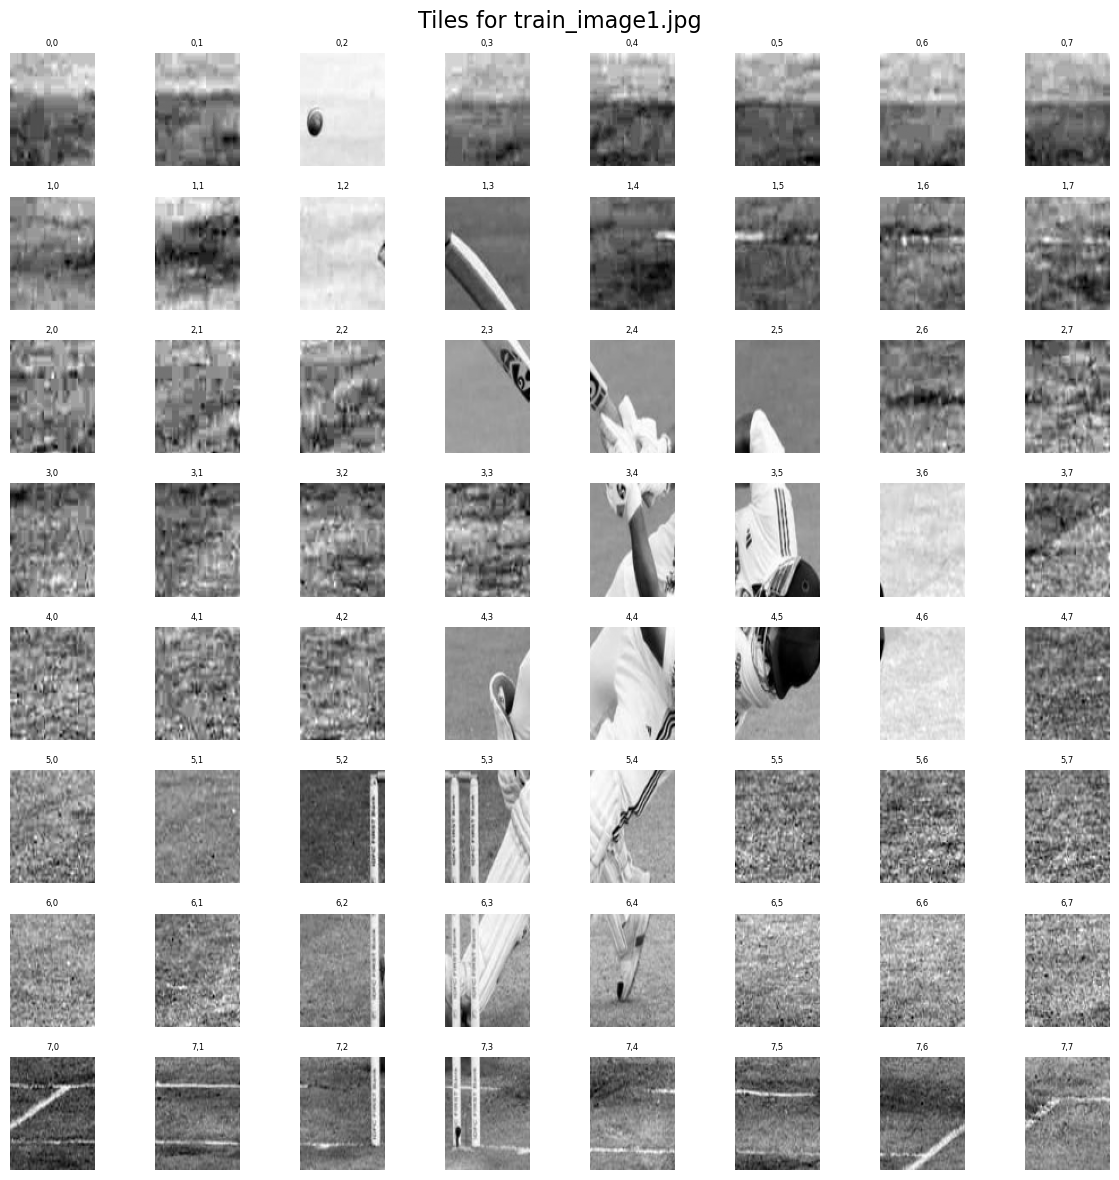

Extracted HOG features for train_image1.jpg, total tiles: 64 and size of each tile feature vector: 3168


c:\Users\SUSHANT\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracted LBP features for train_image1.jpg, total tiles: 64 and size of each tile feature vector: 26


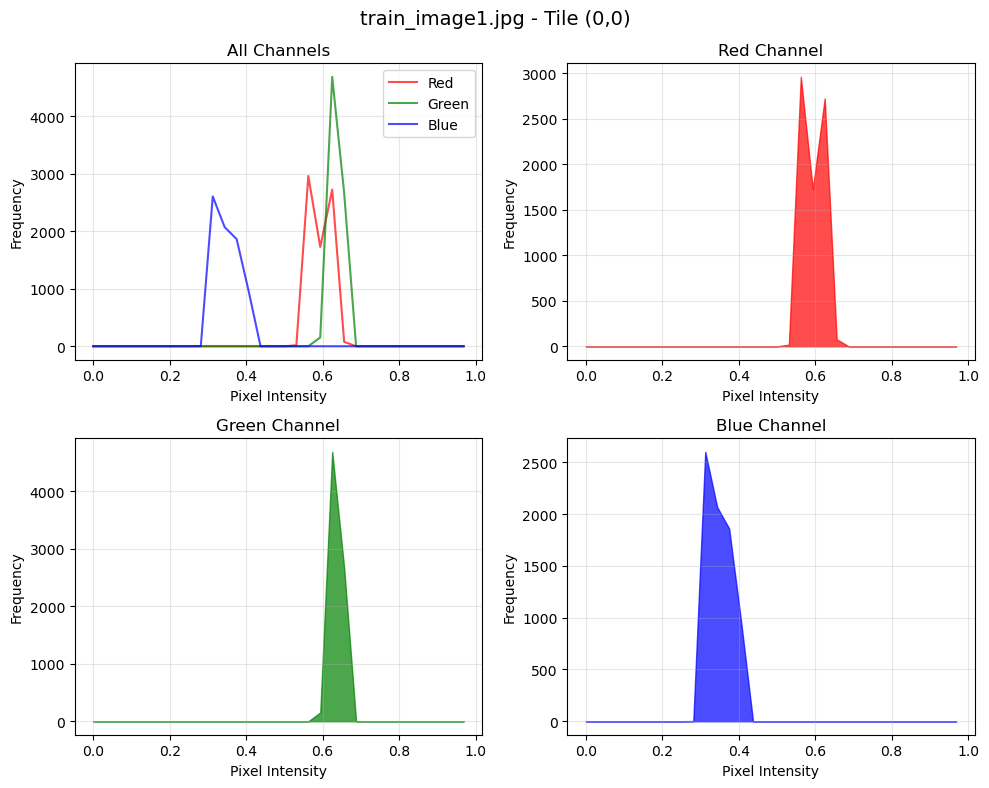

Extracted Color Histogram features for train_image1.jpg, total tiles: 64 and size of each tile feature vector: 96
Saved 64 records to features_data_grp.csv
Shape: (64, 3293)
Columns: ['image', 'tile_i', 'tile_j', 'x_hog_0', 'x_hog_1', 'x_hog_2', 'x_hog_3', 'x_hog_4', 'x_hog_5', 'x_hog_6']...


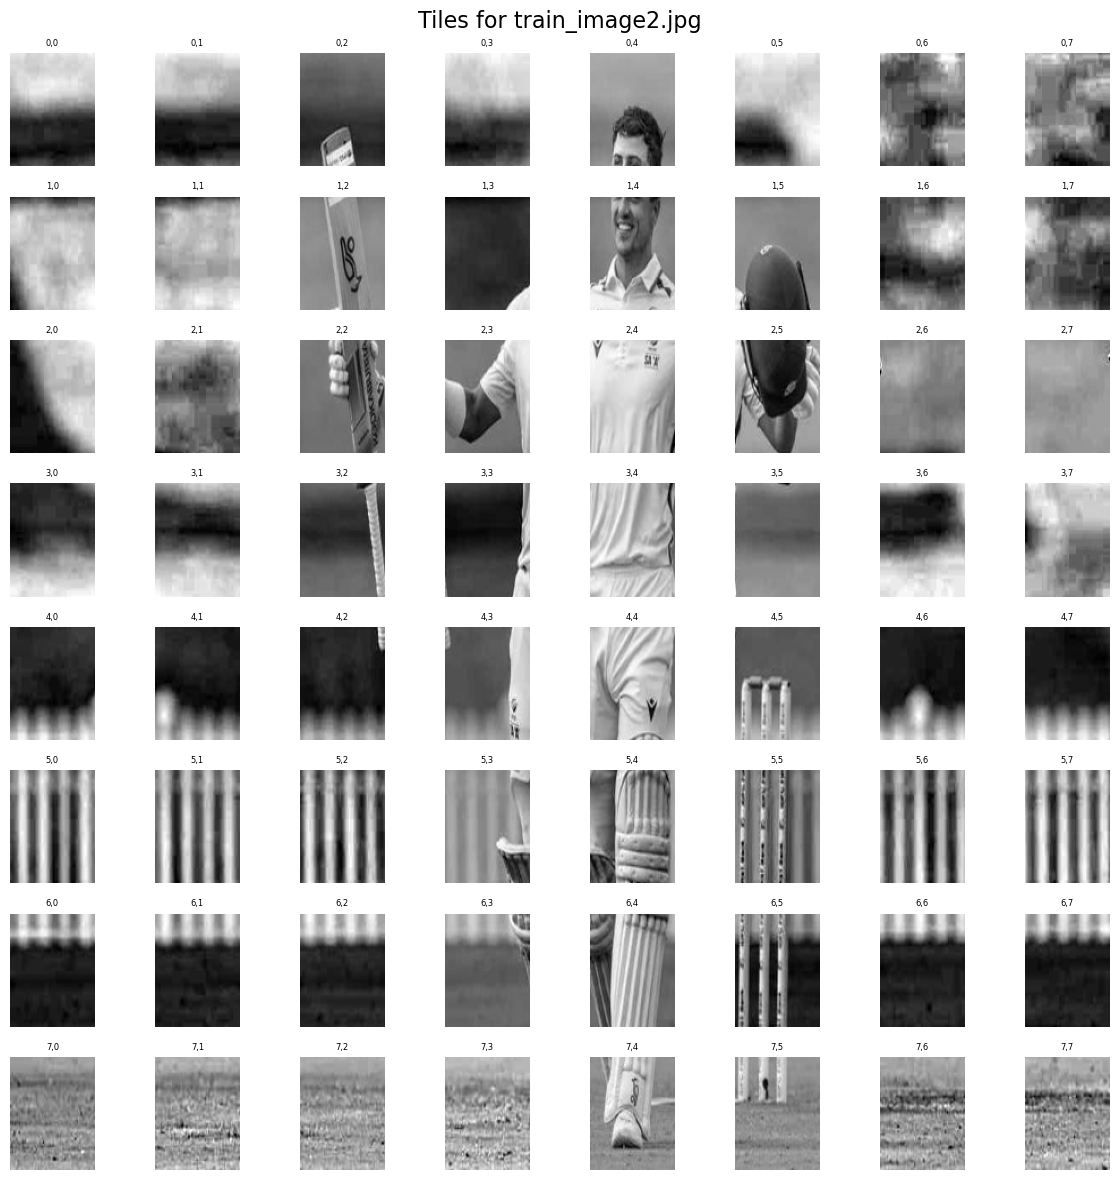

Extracted HOG features for train_image2.jpg, total tiles: 64 and size of each tile feature vector: 3168


c:\Users\SUSHANT\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracted LBP features for train_image2.jpg, total tiles: 64 and size of each tile feature vector: 26


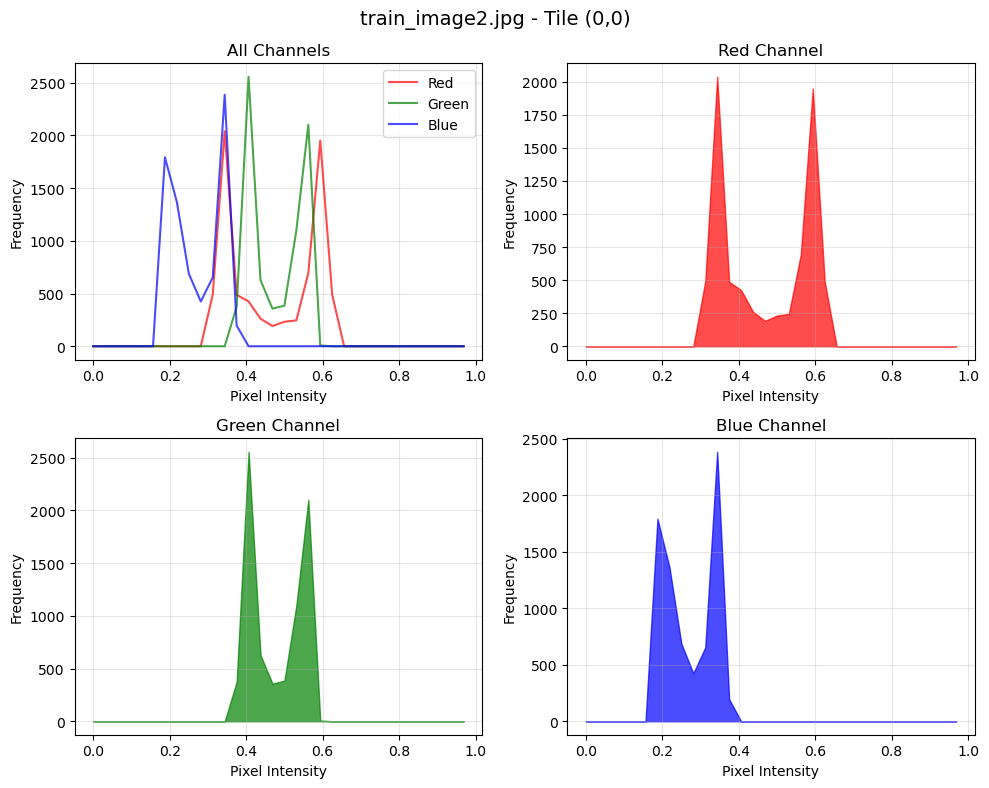

Extracted Color Histogram features for train_image2.jpg, total tiles: 64 and size of each tile feature vector: 96
Saved 128 records to features_data_grp.csv
Shape: (128, 3293)
Columns: ['image', 'tile_i', 'tile_j', 'x_hog_0', 'x_hog_1', 'x_hog_2', 'x_hog_3', 'x_hog_4', 'x_hog_5', 'x_hog_6']...


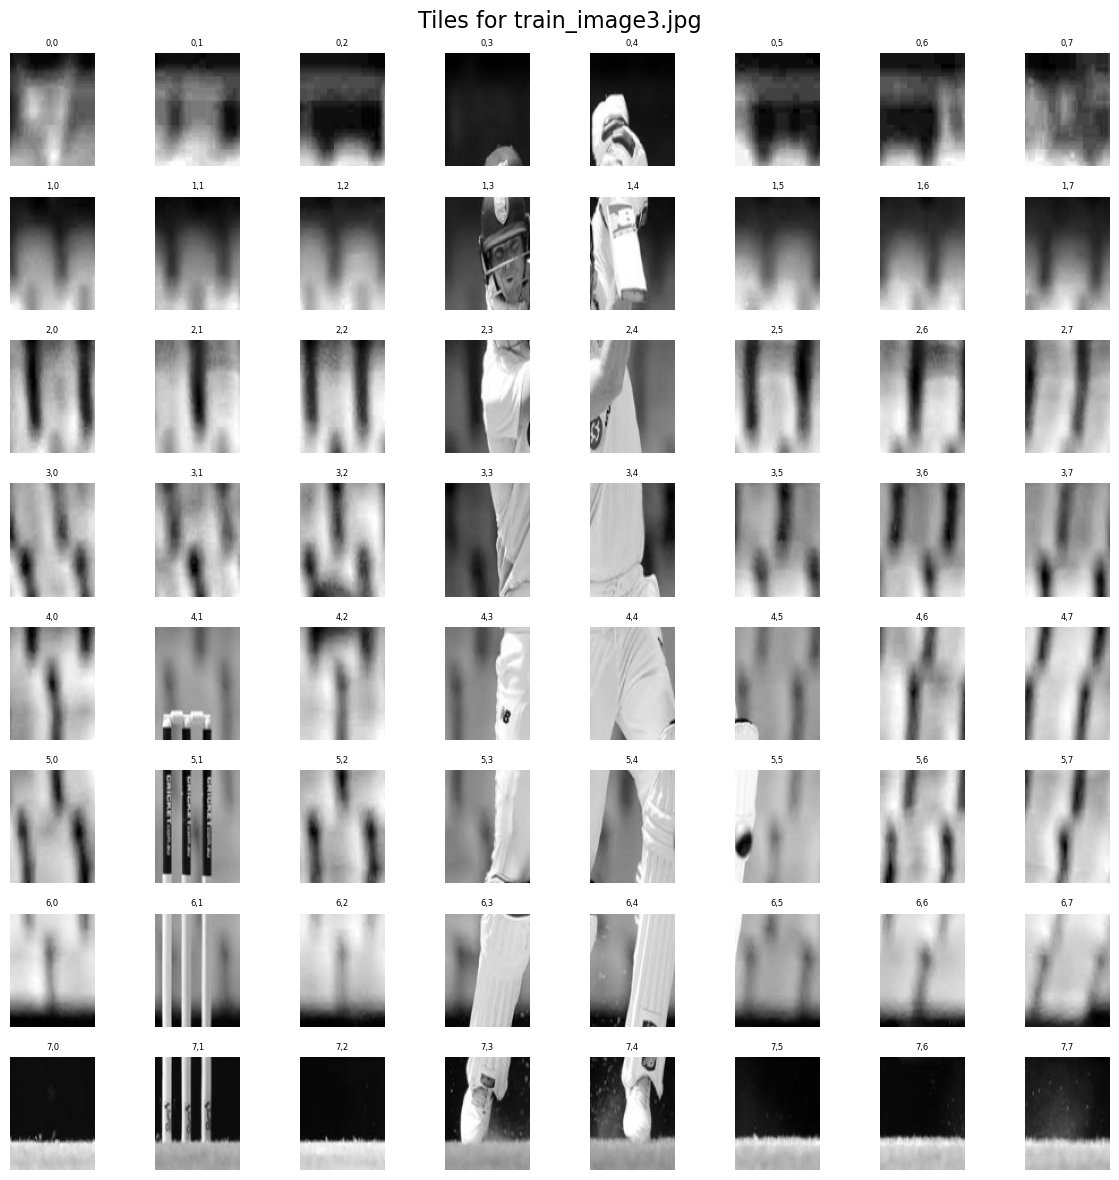

Extracted HOG features for train_image3.jpg, total tiles: 64 and size of each tile feature vector: 3168


c:\Users\SUSHANT\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracted LBP features for train_image3.jpg, total tiles: 64 and size of each tile feature vector: 26


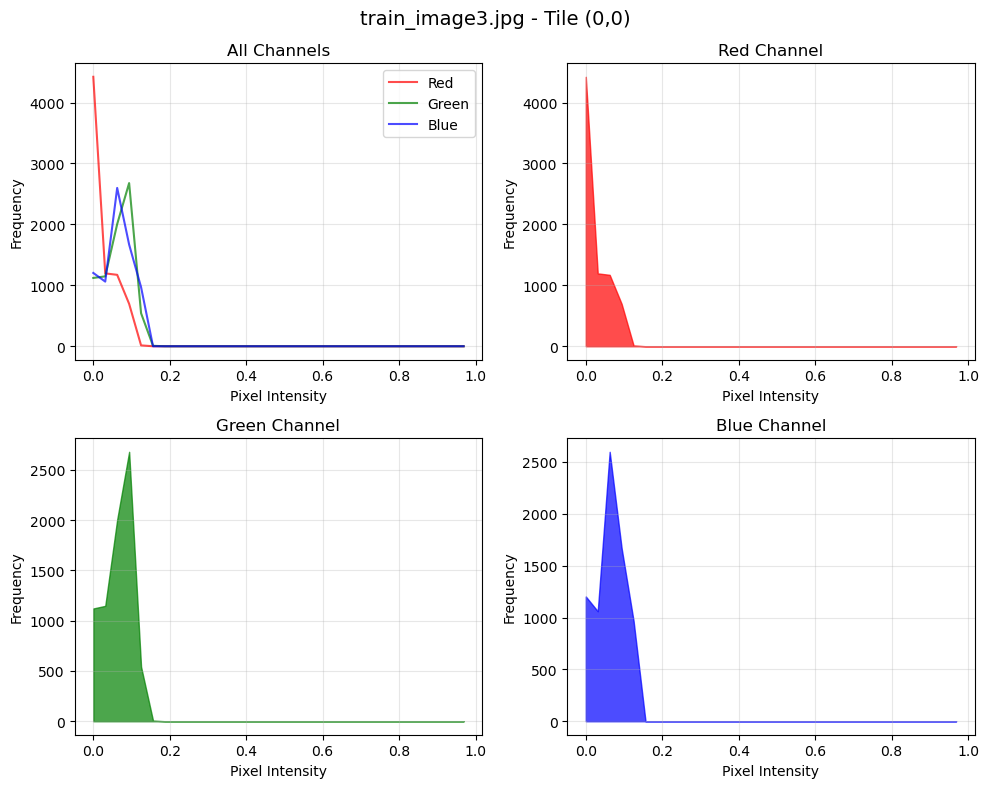

Extracted Color Histogram features for train_image3.jpg, total tiles: 64 and size of each tile feature vector: 96
Saved 192 records to features_data_grp.csv
Shape: (192, 3293)
Columns: ['image', 'tile_i', 'tile_j', 'x_hog_0', 'x_hog_1', 'x_hog_2', 'x_hog_3', 'x_hog_4', 'x_hog_5', 'x_hog_6']...


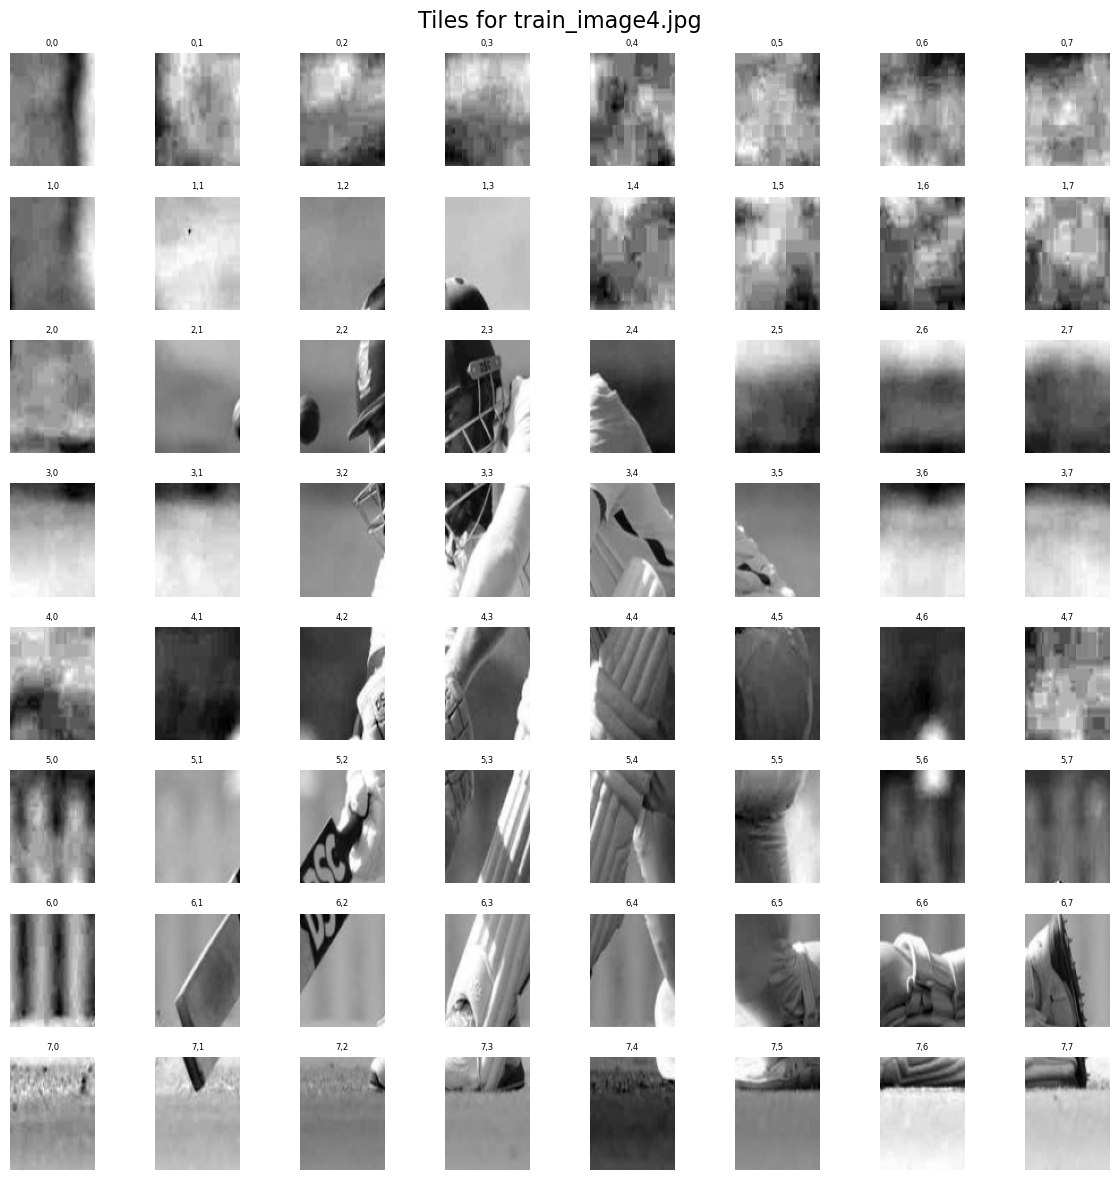

Extracted HOG features for train_image4.jpg, total tiles: 64 and size of each tile feature vector: 3168
Extracted LBP features for train_image4.jpg, total tiles: 64 and size of each tile feature vector: 26


c:\Users\SUSHANT\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


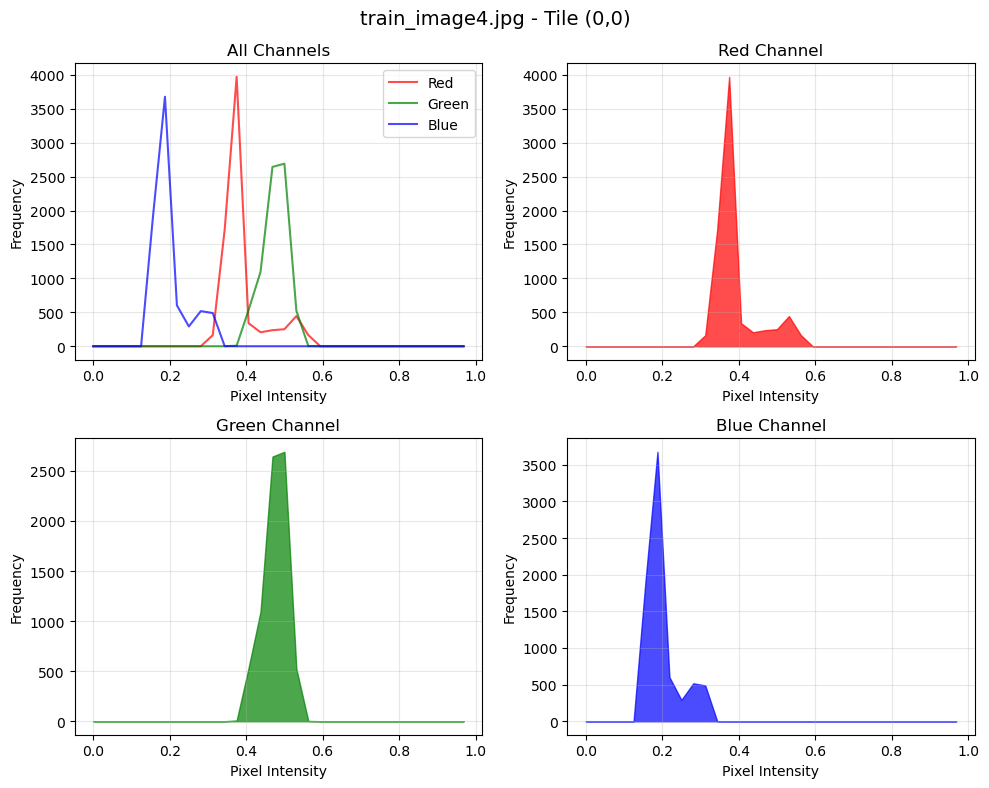

Extracted Color Histogram features for train_image4.jpg, total tiles: 64 and size of each tile feature vector: 96
Saved 256 records to features_data_grp.csv
Shape: (256, 3293)
Columns: ['image', 'tile_i', 'tile_j', 'x_hog_0', 'x_hog_1', 'x_hog_2', 'x_hog_3', 'x_hog_4', 'x_hog_5', 'x_hog_6']...


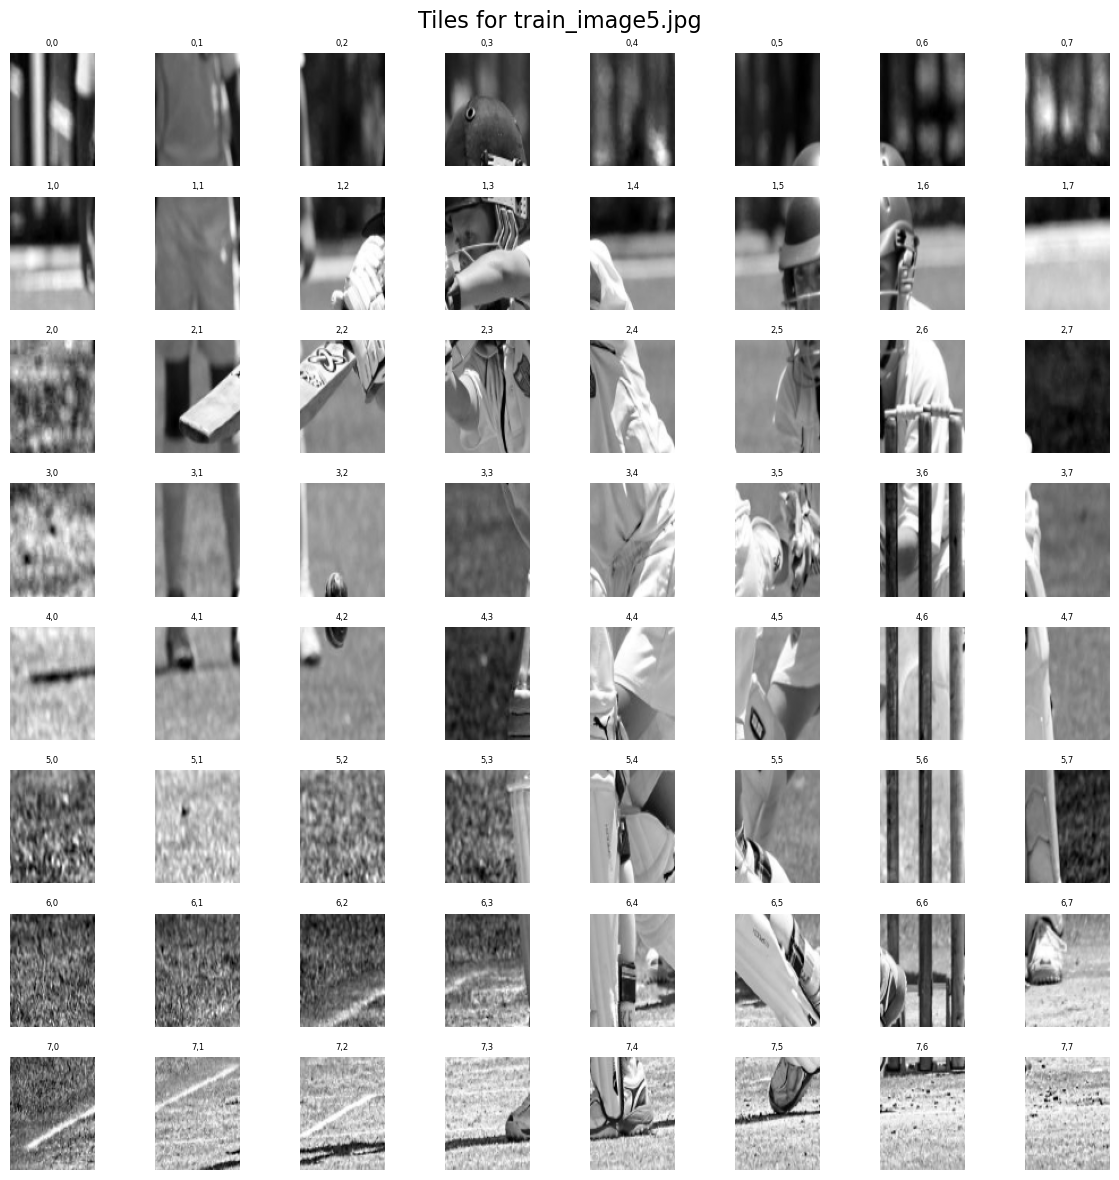

Extracted HOG features for train_image5.jpg, total tiles: 64 and size of each tile feature vector: 3168


c:\Users\SUSHANT\anaconda3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


Extracted LBP features for train_image5.jpg, total tiles: 64 and size of each tile feature vector: 26


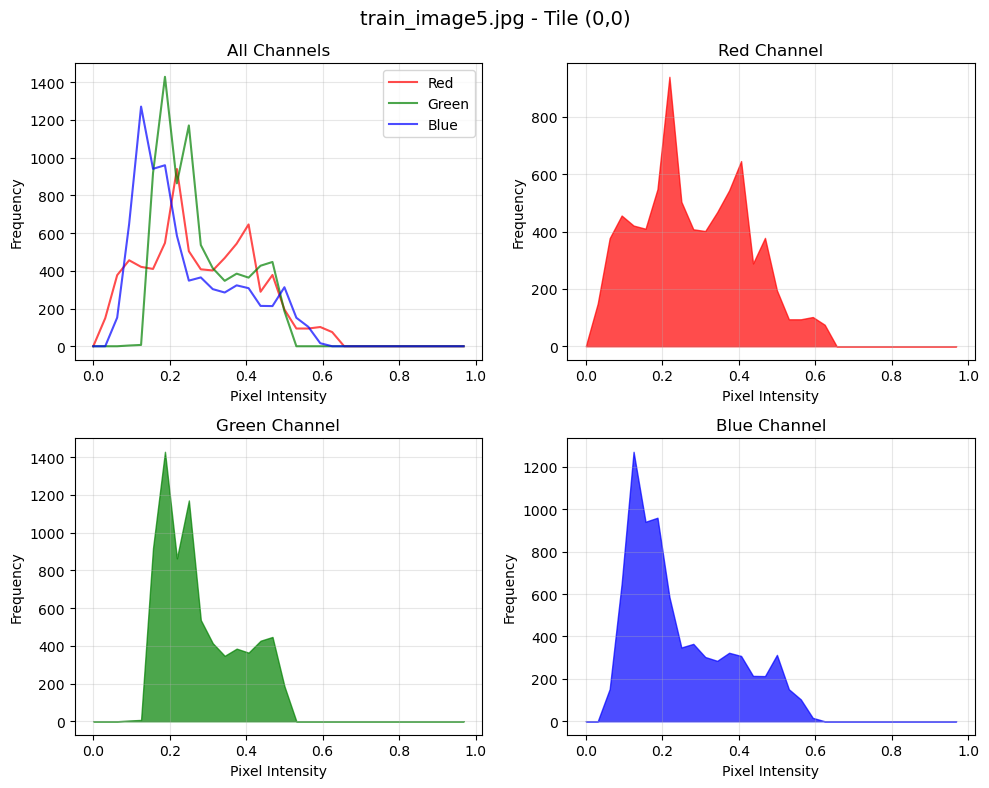

Extracted Color Histogram features for train_image5.jpg, total tiles: 64 and size of each tile feature vector: 96
Saved 320 records to features_data_grp.csv
Shape: (320, 3293)
Columns: ['image', 'tile_i', 'tile_j', 'x_hog_0', 'x_hog_1', 'x_hog_2', 'x_hog_3', 'x_hog_4', 'x_hog_5', 'x_hog_6']...


In [27]:
#Run the extraction
for file in os.listdir(data_dir):
    hog_features = extract_hog_features(file)
    print(f'Extracted HOG features for {file}, total tiles: {len(hog_features)} and size of each tile feature vector: {len(next(iter(hog_features.values())))}')
    lbp_features = extract_lbp_features(file)
    print(f'Extracted LBP features for {file}, total tiles: {len(lbp_features)} and size of each tile feature vector: {len(next(iter(lbp_features.values())))}')
    color_histogram_features = extract_color_histogram_features(file)
    print(f'Extracted Color Histogram features for {file}, total tiles: {len(color_histogram_features)} and size of each tile feature vector: {len(next(iter(color_histogram_features.values())))}')
    write_features_to_file()

In [ ]:
__test_